In [20]:
using TCI4Keldysh
using PythonPlot
using PythonCall
using MAT
using LinearAlgebra

INCH_TO_PT = 72
PT_TO_INCH = 1.0/INCH_TO_PT
COLUMN_PT = 432
COLUMN_INCH = COLUMN_PT*PT_TO_INCH
PLOT_COLUMN_PT = 420
PLOT_COLUMN_INCH = PLOT_COLUMN_PT*PT_TO_INCH
PLOT_PAGE_PT = PLOT_COLUMN_PT*2
PLOT_PAGE_INCH = PLOT_PAGE_PT*PT_TO_INCH


# setup
channel = "t"
base_path = "SIAM_u=0.50"
PSFpath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50/PSF_nz=4_conn_zavg/")
Vpath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50", "V_KF_" * TCI4Keldysh.channel_translate(channel))
flavor = 1

1

In [24]:
# load MuNRG
# In the MuNRG data, the Keldysh components of Σ are stored on a 4-fold duplicated 1D grid,
# in the order: (11) (21) (12) (22)
# MuNRG code: Multipoint/get_V_4pIE.m; uses asymmetricIE
Σnames = ["SE_KF_$i.mat" for i in 1:4]
Σs = Vector{ComplexF64}[]
grids = Vector{Float64}[]
for Σname in Σnames
    matopen(joinpath(Vpath, Σname), "r") do f
        CFdat = read(f, "CFdat")
        Σ_act = CFdat["Ggrid"][flavor]
        grid_act = CFdat["ogrid"][flavor]
        push!(Σs, vec(Σ_act))
        push!(grids, vec(real.(grid_act)))
    end
end
@show size.(Σs)
@show size.(grids)
# check whether all frequency grids are the same
@assert all(length.(grids) .== length(first(grids)))
for g in grids[2:4]
    @assert maximum(abs.(g .- grids[1])) < 1.e-12
end


size.(Σs) = [(1604,), (1604,), (1604,), (1604,)]
size.(grids) = [(401,), (401,), (401,), (401,)]


In [30]:
# Julia, calculate everything seperately
(γ, sigmak) = TCI4Keldysh.read_broadening_params(base_path; channel=channel)
broadening_kwargs = TCI4Keldysh.read_broadening_settings(joinpath(TCI4Keldysh.datadir(), base_path); channel=channel)
broadening_kwargs[:estep] = 200
omsig = grids[1]
flavor_idx = flavor

T = TCI4Keldysh.dir_to_T(PSFpath)
ωconvMat = TCI4Keldysh.ωconvMat_K1()
# precompute correlators
G = TCI4Keldysh.FullCorrelator_KF(PSFpath, ["F1", "F1dag"]; T, flavor_idx=flavor_idx, ωs_ext=(omsig,), ωconvMat=ωconvMat, sigmak=sigmak, γ, broadening_kwargs...)
G_aux_L = TCI4Keldysh.FullCorrelator_KF(PSFpath, ["F1", "Q1dag"]; T, flavor_idx=flavor_idx, ωs_ext=(omsig,), ωconvMat=ωconvMat, sigmak=sigmak, γ, broadening_kwargs...)
G_aux_R = TCI4Keldysh.FullCorrelator_KF(PSFpath, ["Q1", "F1dag"]; T, flavor_idx=flavor_idx, ωs_ext=(omsig,), ωconvMat=ωconvMat, sigmak=sigmak, γ, broadening_kwargs...)
G_data = TCI4Keldysh.precompute_all_values(G)
G_aux_L_data = TCI4Keldysh.precompute_all_values(G_aux_L)
G_aux_R_data = TCI4Keldysh.precompute_all_values(G_aux_R)

G_data_fdt = TCI4Keldysh.precompute_all_values_FDT(PSFpath, ["F1", "F1dag"], omsig; flavor_idx=flavor_idx, T=T, γ=γ, sigmak=sigmak, broadening_kwargs...)
G_aux_L_data_fdt = TCI4Keldysh.precompute_all_values_FDT(PSFpath, ["F1", "Q1dag"], omsig; flavor_idx=flavor_idx, T=T, γ=γ, sigmak=sigmak, broadening_kwargs...)
G_aux_R_data_fdt = TCI4Keldysh.precompute_all_values_FDT(PSFpath, ["Q1", "F1dag"], omsig; flavor_idx=flavor_idx, T=T, γ=γ, sigmak=sigmak, broadening_kwargs...)


# deduce self-energies
X = TCI4Keldysh.get_PauliX()
I = diagm([1.0,1.0])
Σ_L = zeros(ComplexF64, size(G_data))
for i in axes(Σ_L,1)
    Σ_L[i,:,:] .= X*G_aux_L_data[i,:,:]/G_data[i,:,:]
end
Σ_R = zeros(ComplexF64, size(G_data))
for i in axes(Σ_R,1)
    Σ_R[i,:,:] .= (I/G_data[i,:,:]) * G_aux_R_data[i,:,:] * X
end

    # Σ for fdt
Σ_L_fdt = zeros(ComplexF64, size(G_data_fdt))
for i in axes(Σ_L,1)
    Σ_L_fdt[i,:,:] .= X*G_aux_L_data_fdt[i,:,:]/G_data_fdt[i,:,:]
end
Σ_R_fdt = zeros(ComplexF64, size(G_data_fdt))
for i in axes(Σ_R,1)
    Σ_R_fdt[i,:,:] .= (I/G_data_fdt[i,:,:]) * G_aux_R_data_fdt[i,:,:] * X
end

Loading stuff:   0.001826 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  81.310000 seconds (50.56 M allocations: 170.864 GiB, 5.17% gc time)
All the rest:   1.693809 seconds (166.05 k allocations: 1.589 GiB, 43.57% gc time)
Loading stuff:   0.001601 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  81.653153 seconds (50.56 M allocations: 170.865 GiB, 5.35% gc time)
All the rest:   1.597691 seconds (166.83 k allocations: 1.596 GiB, 47.24% gc time)
Loading stuff:   0.002191 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  80.245494 seconds (50.56 M allocations: 170.865 GiB, 5.82% gc time)
All the rest:   1.663351 seconds (166.83 k allocations: 1.596 GiB, 43.99% gc time)
Broaden...
Compute Aconts...
Compute G^K...
Compute G^R and G^A...
Broaden...
Compute Aconts...
Compute G^K...
Compute G^R and G^A...
Broaden...
Compute Aconts...
Compute G^K...
Compute G^R and G^A...


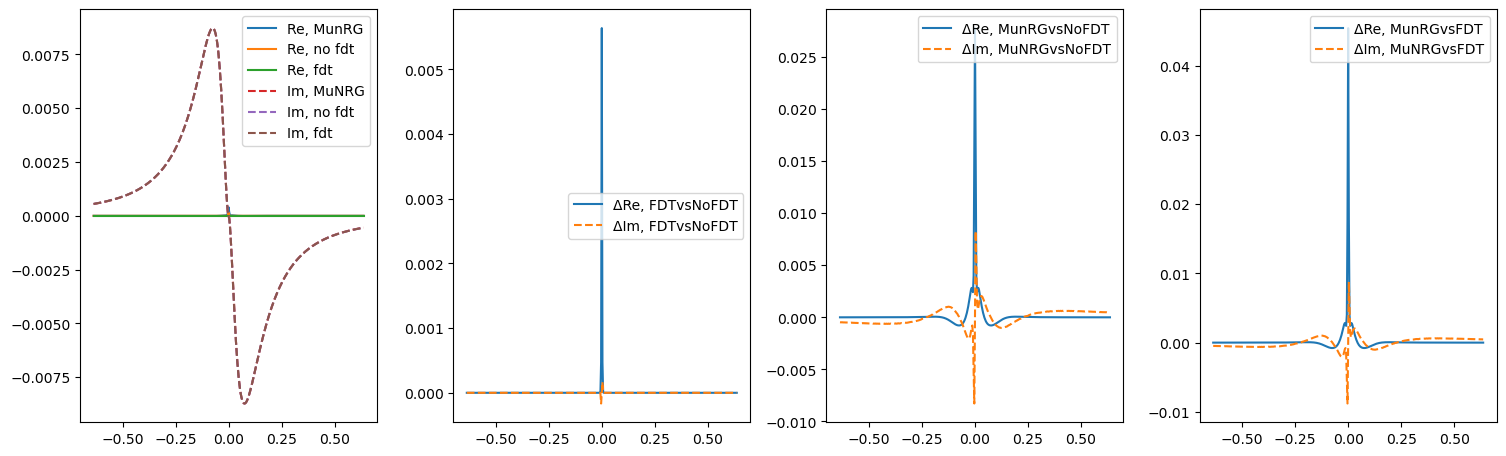

2×2 Matrix{ComplexF64}:
          0.0+0.0im       -0.000616279+0.783935im
 -0.000616279-0.783935im           0.0+0.00483181im

2×2 Matrix{ComplexF64}:
          0.0+0.0im       -0.000616279+0.783935im
 -0.000616279-0.783935im           0.0+0.0im

2×2 Matrix{ComplexF64}:
 2.73691e-48-1.80655e-17im  3.6131e-17+0.0318904im
  3.6131e-17-0.0318904im           0.0+0.0im

2×2 Matrix{ComplexF64}:
        -0.0+0.0im        6.42878e-17+0.0318904im
 6.42878e-17-0.0318904im          0.0+0.0im

2×2 Matrix{ComplexF64}:
 0.000154088+1.85712e-19im  0.025-1.96534e-5im
       0.025+1.96534e-5im     0.0+0.0im

2×2 Matrix{ComplexF64}:
   0.0+0.0im         0.025-1.96534e-5im
 0.025+1.96534e-5im    0.0+0.0im

In [119]:
# plot self-energies; biggest discrepancy in MuNRG vs Julia is in k=(11) component of Σ

fig, axs = subplots(1,4, figsize=(1.3*PLOT_PAGE_INCH, PLOT_PAGE_INCH*4/10))

window = 1:401
omsig = grids[1]
sig = Σs[1][1 : length(omsig)]
omsig = omsig[window]
axs[0].plot(omsig, real.(sig[window]),  label="Re, MunRG")
axs[0].plot(omsig, real.(Σ_L[window, 1, 1]),  label="Re, no fdt")
axs[0].plot(omsig, real.(Σ_L_fdt[window, 1, 1]),  label="Re, fdt")
axs[0].plot(omsig, imag.(sig[window]),  linestyle="dashed",  label="Im, MuNRG")
axs[0].plot(omsig, imag.(Σ_L[window, 1, 1]),  linestyle="dashed",  label="Im, no fdt")
axs[0].plot(omsig, imag.(Σ_L_fdt[window, 1, 1]),  linestyle="dashed",  label="Im, fdt")
axs[0].legend()

# errors
nn = maximum(abs.(Σ_L))
dFDT = (Σ_L .- Σ_L_fdt) ./ nn
dMat = (sig .- Σ_L) ./ nn
dMatFDT = (sig .- Σ_L_fdt) ./ nn

# axs[1].set_yscale("log")
axs[1].plot(omsig, (real.(dFDT[window, 1, 1])),  label="ΔRe, FDTvsNoFDT")
axs[1].plot(omsig, (imag.(dFDT[window, 1, 1])),  linestyle="dashed",  label="ΔIm, FDTvsNoFDT")
axs[1].legend()


nn = maximum(abs.(Σ_L[:,1,1]))
dFDT = (Σ_L .- Σ_L_fdt) ./ nn
dMat = (sig .- Σ_L) ./ nn
dMatFDT = (sig .- Σ_L_fdt) ./ nn
axs[2].plot(omsig, (real.(dMat[window, 1, 1])),  label="ΔRe, MunRGvsNoFDT")
axs[2].plot(omsig, (imag.(dMat[window, 1, 1])),  linestyle="dashed",  label="ΔIm, MuNRGvsNoFDT")
# axs[1].set_yscale("log")
axs[2].legend()

axs[3].plot(omsig, (real.(dMatFDT[window, 1, 1])),  label="ΔRe, MunRGvsFDT")
axs[3].plot(omsig, (imag.(dMatFDT[window, 1, 1])),  linestyle="dashed",  label="ΔIm, MuNRGvsFDT")
axs[3].legend()

fig.tight_layout()
display(fig)
idx = 201
display(G_aux_L_data[idx,:,:])
display(G_aux_L_data_fdt[idx,:,:])
display(inv(G_data[idx,:,:]))
display(inv(G_data_fdt[idx,:,:]))
display(X * G_aux_L_data[idx,:,:] * inv(G_data[idx,:,:]))
display(X * G_aux_L_data_fdt[idx,:,:] * inv(G_data_fdt[idx,:,:]))

The reason for the discrepancy between Julia and MuNRG in $\Re(\Sigma^{(11)})$ around $\omega=0$, which is the biggest error,
lies in the fact that in MuNRG $\Re(\Sigma^{(11)})\neq 0$, which is forbidden by the FDT.

Looking at $\Sigma_L^{(11)}(\omega=0)$, we see that $G_{aux}^{(22)}(\omega=0)\neq 0$ if $G_{aux}$ is computed without FDT. This leads
to two nonzero numbers being multiplied in $\Sigma_L^{(11)}(\omega=0)$.

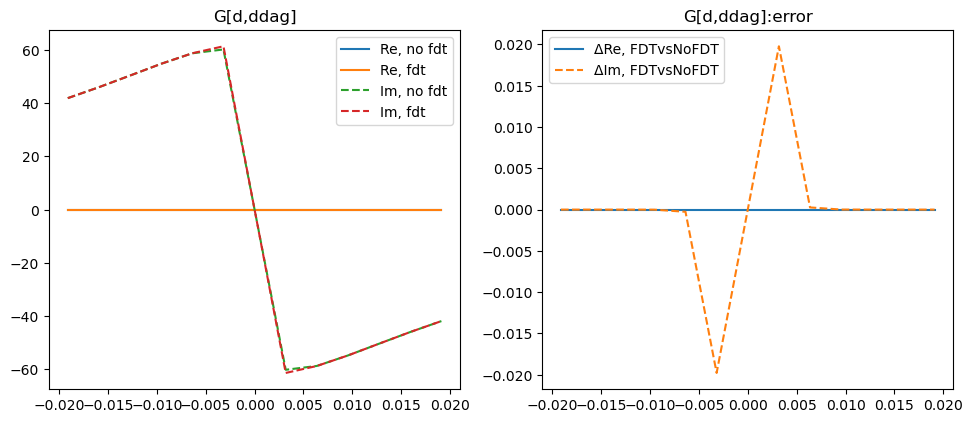

In [73]:
# plot impurity Green's function; biggest discrepancy in MuNRG vs Julia is in k=(11) component of Σ

fig, axs = subplots(1,2, figsize=(PLOT_PAGE_INCH, PLOT_PAGE_INCH*4/10))

window = 195:207
omsig = grids[1]
omsig = omsig[window]

axs[0].plot(omsig, real.(G_data[window, 2,2]),  label="Re, no fdt")
axs[0].plot(omsig, real.(G_data_fdt[window, 2,2]),  label="Re, fdt")
axs[0].plot(omsig, imag.(G_data[window, 2,2]),  linestyle="dashed",  label="Im, no fdt")
axs[0].plot(omsig, imag.(G_data_fdt[window, 2,2]),  linestyle="dashed",  label="Im, fdt")
axs[0].set_title("G[d,ddag]")
axs[0].legend()

# errors
nn = maximum(abs.(G_data))
dFDT = (G_data .- G_data_fdt) ./ nn
axs[1].plot(omsig, (real.(dFDT[window, 2,2])),  label="ΔRe, FDTvsNoFDT")
axs[1].plot(omsig, (imag.(dFDT[window, 2,2])),  linestyle="dashed",  label="ΔIm, FDTvsNoFDT")
# axs[1].set_yscale("log")
axs[1].set_title("G[d,ddag]:error")
axs[1].legend()

display(fig)

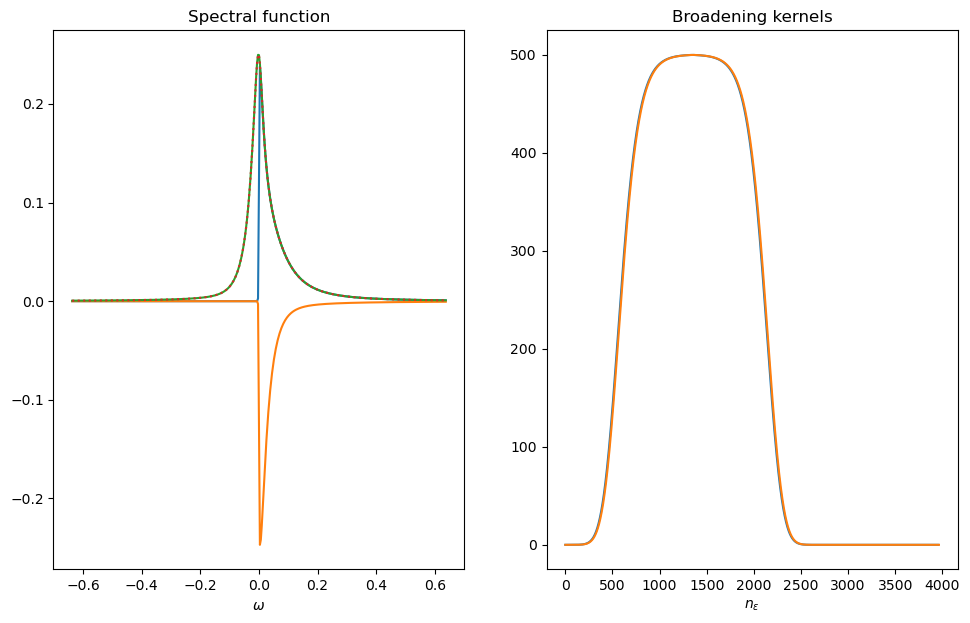

size(G_aux_L.GR_to_GK) = (2, 4, 2)
G_aux_L.Gp_to_G = [1.0, -1.0]
(G_aux_L.Gps[1]).ωconvMat = [1;;]
(G_aux_L.Gps[2]).ωconvMat = [-1;;]
(-2π) * (A12[201] + A21[201]) = 0.0048318140102390755
(G_aux_L.ωs_ext[1])[201] = 0.0
size(omdisc) = (5909,)
omdisc[div(length(omdisc), 2) + 1] = 0.0


0.0

In [170]:
@show size(G_aux_L.GR_to_GK)
# display(G_aux_L.GR_to_GK[:,:,1])
# display(G_aux_L.GR_to_GK[:,:,2])
@show G_aux_L.Gp_to_G
@show G_aux_L.Gps[1].ωconvMat
@show G_aux_L.Gps[2].ωconvMat

# idx = 202
# display(sig[idx])
# display(Σ_L[idx,1,1])
# display(Σ_L_fdt[idx,1,1])

# examine partial spectral functions at ω=0
Gp12 = G_aux_L.Gps[1].tucker
A12 = -1/π * imag.(Gp12.legs[1] * Gp12.center)
Gp21 = G_aux_L.Gps[2].tucker
A21 = -1/π * imag.(Gp21.legs[1] * Gp21.center)

fig, ax = subplots(1,2, figsize=(PLOT_PAGE_INCH, 3/5 * PLOT_PAGE_INCH))
ax[0].plot(G_aux_L.ωs_ext[1], A12, label="A12")
ax[0].plot(G_aux_L.ωs_ext[1], A21, label="A21")
ax[0].plot(G_aux_L.ωs_ext[1], -reverse(A21) .+ A12, label="A12(ω)+A21(-ω)")
ax[0].plot(G_aux_L.ωs_ext[1], -1/π * imag.(G_aux_L_data[:,2,1]), label="A", linestyle="dotted")
ax[0].set_xlabel(L"\omega")
ax[0].set_title("Spectral function")
# this is the value appearing in ℑ(G_aux^(22)(ω=0))
@show -2π*(A12[201] + A21[201])
# check that it's 0.0
@show G_aux_L.ωs_ext[1][201]

# plot broadening kernels at ω=0
idx = 201
ax[1].plot(-1/π * imag.(Gp12.legs[1][idx,:]))
ax[1].plot(-1/π * imag.(Gp21.legs[1][idx,:]))
ax[1].set_title("Broadening kernels")
ax[1].set_xlabel(L"n_\epsilon")
display(fig)
# @show Gp12.ωs_center[1][div(3957,2)-10:div(3957,2)+1]
omdisc = TCI4Keldysh.load_ωdisc(PSFpath, ["F1", "Q1dag"])
@show size(omdisc)
@show omdisc[div(length(omdisc),2)+1]

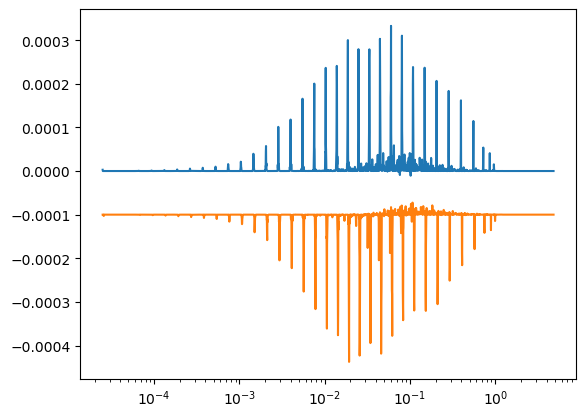

Gp12.center[omtest] = 0.00033272571883238345 + 0.0im
Gp21.center[omtest] = 1.719605821545127e-5 + 0.0im


1.719605821545127e-5 + 0.0im

In [179]:
# plot discrete PSFs
fig, ax = subplots()

Gp12 = G_aux_L.Gps[1].tucker
Gp21 = G_aux_L.Gps[2].tucker
omdisc = Gp12.ωs_center[1]
posid = [i for i in 1:length(omdisc) if omdisc[i]>0.0]
ax.plot(omdisc[posid], Gp12.center[posid])
ax.plot(omdisc[posid], Gp21.center[posid] .- 1.e-4)
ax.set_xscale("log")
display(fig)

# evaluate at same frequency
omtest = argmax(abs.(Gp12.center))
@show Gp12.center[omtest]
@show Gp21.center[omtest]